# Algoritmo de detecção de arritmia

O algorítmo da MLP foi enviado junto com o restante do trabalho, porém também pode ser visto em: https://github.com/GuilhermeSpadaccia/MachineLearning

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import pywt
import seaborn as sns

from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix

import neural_network
from sklearn.model_selection import train_test_split

from operator import itemgetter

from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve
from matplotlib import pyplot

## Defininição dos conjuntos de treinamento e teste.
Por termos classes muito desbalanceadas foi optado por fazer a validação do resultado usando a técnica de Holdout, dessa forma possuimos apenas conjuntos de treino e teste.

In [3]:
files_train = ['101', 
             '106', 
             '108', 
             '109', 
             '112', 
             '114', 
             '115', 
             '116', 
             '118', 
             '119', 
             '122', 
             '124', 
             '201', 
             '203', 
             '205', 
             '207', 
             '208', 
             '209', 
             '215', 
             '220', 
             '223', 
             '230']


In [4]:
files_test = ['100', 
             '103', 
             '105', 
             '111', 
             '113', 
             '117', 
             '121', 
             '123', 
             '200', 
             '202', 
             '210', 
             '212', 
             '213', 
             '214', 
             '219', 
             '221', 
             '222', 
             '228', 
             '231', 
             '232', 
             '233', 
             '234']
             

## Funções gerais
Declarações de funções usadas pelo algoritmo

In [5]:
def gaussian_smoothing(data, window=5, std=1):
    gauss = gaussian(window ,std, sym=True)
    data = np.convolve(gauss/gauss.sum(), data, mode='same')
    return data

def gauss_wrapper(data):
    return gaussian_smoothing(data, 12, 7)

def apply_wavelet(data):
    # https://pywavelets.readthedocs.io/en/latest/
    wavelet_signal = pywt.swt(data, wavelet = "haar", level=1, start_level=0, axis=-1)
    return wavelet_signal[0][1]

## Função return_annotation
Função responsável por retornar as anotações de um determinado arquivo de ECG, nele temos a informação de onde estão localizados as ondas R.

In [7]:
def return_annotation_df(file):
    annotation = []
    annotation_aux = []
    header = []
    
    # Leio o arquivo .txt com as anotações
    time_tp = (0,12)
    sample_tp = (12, 21)
    type_beat_tp = (21, 27)
    sub_tp = (27, 32)
    chan_tp = (32, 37)
    num_tp = (37, 42)
    aux_tp = (42, 0)
    
    with open('data/kaggle/'+file+'annotations.txt') as f:
        annotation_text = f.readlines()

    for text in annotation_text:
        annotation_aux.append(text[time_tp[0]:time_tp[1]].strip())
        annotation_aux.append(text[sample_tp[0]:sample_tp[1]].strip())
        annotation_aux.append(text[type_beat_tp[0]:type_beat_tp[1]].strip())
        annotation_aux.append(text[sub_tp[0]:sub_tp[1]].strip())
        annotation_aux.append(text[chan_tp[0]:chan_tp[1]].strip())
        annotation_aux.append(text[num_tp[0]:num_tp[1]].strip())
        annotation_aux.append(text[aux_tp[0]:].replace('\t', '').replace('\n', '').strip())

        if len(header) < 1:
            header = annotation_aux.copy()
        else:
            annotation.append(annotation_aux)
        annotation_aux = []
    
    # Gero um DataFrame com as anotações
    annotations_df = pd.DataFrame(annotation, columns=header)
    annotations_df['Sample #'] = pd.to_numeric(annotations_df['Sample #'])
    
    return annotations_df

## Pré processamento

Processo responsável por gerar as features utilizadas no modelo.

In [8]:
def q_wave(wave, ini, pos):
    if wave[pos] < wave[ini:pos].mean():
        wave = wave*-1
        
    return wave[ini:pos].idxmin()

def s_wave(wave, end, pos):
    if wave[pos] < wave[pos:end].mean():
        wave = wave*-1
        
    return wave[pos:end].idxmin()

In [10]:
# Defino o tamanho da janela usada
window = 1
rr_intervals = []
qrs_intervals = []
def pre_proccess(files):

    features_dataset = []
    for file in files:
        # Abro o arquivo CSV com a leitura de ECG do individuo
        df = pd.read_csv('data/kaggle/'+file+'.csv')

        df["data_wavelet"] = apply_wavelet(df["'MLII'"])
        df["data_norm"] = gaussian_smoothing(df["'MLII'"], 8, 2)

        annotations_df = return_annotation_df(file)

        # Utilizando as anotações encontro a onda R e corto um trecho do batimento
        # A janela utilizada no corte é definida pelas variaveis ini e end.
        last_pos = None
        
        # defino a lista de atrasos
        aux_list = []
        for index, row in annotations_df.iterrows():
            pos = row['Sample #']

            if last_pos == None:
                last_pos = pos
                continue

            if pos > 70:
                ini = pos - 31
                end = pos + 32

                QRS_wave = df["data_wavelet"][ini:end].values
                QRS_wave_norm = df["data_norm"][ini:end].values
                
                RR_wave = df["data_norm"][last_pos:pos].values
                
                # para criar as features de QRS_ratio e QRS_var utilizo os dados no normalizados pela wavelet
                QRS_max_val = QRS_wave.max()
                QRS_min_val = QRS_wave.min()
                QRS_ratio = QRS_min_val/QRS_max_val
                QRS_var = QRS_wave.var()
                
                # para calcular o QRS_time e RR_distance utilizo os dados normalizados pela função gaussiana
                QRS_max_val = QRS_wave_norm.max()
                QRS_min_val = QRS_wave_norm.min()
                QRS_time = s_wave(df["data_norm"], end, pos) - q_wave(df["data_norm"], ini, pos)
                QRS_diff = QRS_wave_norm.max() - QRS_wave_norm.min()
                QRS_max_rate = np.diff(QRS_wave_norm).max()
                RR_distance = pos - last_pos
                RR_amplitude = RR_wave.max() - RR_wave.min()

                beat_type_n = 0 
                beat_type_an = 1 

                if row['Type'] == 'N':
                    # Normal
                    beat_type_n = 1
                    beat_type_an = 0
                    beat_type_desc = "NORMAL"
                elif row['Type'] in ['A','a','J','S','e','j']:
                    beat_type_desc = "SVEB"
                elif row['Type'] in ['V','E']:
                    beat_type_desc = "VEB"
                elif row['Type'] in ['F']:
                    beat_type_desc = "F"
                elif row['Type'] in ['P','/','f','u']:
                    beat_type_desc = "P"
                else:
                    # Caso não se enquadre em nenhum caso descarto a batida
                    continue
                
                rr_intervals.append([RR_wave,beat_type_an])
                qrs_intervals.append([QRS_wave_norm,beat_type_an])
                
                aux_list.append([QRS_wave_norm,
                             RR_wave,
                             QRS_ratio, 
                             QRS_var, 
                             QRS_time, 
                             QRS_diff,
                             QRS_max_rate,
                             QRS_max_val,
                             QRS_min_val,
                             RR_distance, 
                             beat_type_n,
                             beat_type_an,
                             beat_type_desc,
                             file,
                             RR_amplitude])

            last_pos = pos
        
        features_dataset.append(aux_list)
        
    return features_dataset


## Função calc_rr_window
Calcula as variáveis que dependem de janelamento. São elas: RR_variance, RR_mean e RR_std

In [11]:
def calc_rr_window(pre_proc_files):
    
    for i in range(len(pre_proc_files)):
        proc_file = pd.DataFrame(pre_proc_files[i])
        proc_file.columns = ['QRS_wave',
                        'RR_wave',
                       'QRS_ratio', 
                       'QRS_var', 
                       'QRS_time',
                       'QRS_diff',
                       'QRS_max_rate',
                       'QRS_max',
                       'QRS_min',
                       'RR_distance',
                       'target_n', 
                       'target_an',
                       'target_description',
                       'file',
                       'RR_amplitude']

        df_aux = proc_file[['RR_distance']]
        df_aux['RR_distance-1'] = proc_file['RR_distance'].shift(1)
        df_aux['RR_distance-2'] = proc_file['RR_distance'].shift(2)
        df_aux['RR_distance-3'] = proc_file['RR_distance'].shift(3)
        df_aux['RR_distance-4'] = proc_file['RR_distance'].shift(4)
        df_aux['RR_distance-5'] = proc_file['RR_distance'].shift(5)
        df_aux['RR_distance-6'] = proc_file['RR_distance'].shift(6)
        df_aux['RR_distance-7'] = proc_file['RR_distance'].shift(7)
        df_aux['RR_distance-8'] = proc_file['RR_distance'].shift(8)
        df_aux['RR_distance-9'] = proc_file['RR_distance'].shift(9)

        df_aux = df_aux.dropna()

        df_aux['RR_variance'] = df_aux.var(axis=1)
        df_aux['RR_mean'] = df_aux.mean(axis=1)
        df_aux['RR_std'] = df_aux.std(axis=1)

        df_aux = df_aux.drop(['RR_distance',
                              'RR_distance-1',
                              'RR_distance-2',
                              'RR_distance-3',
                              'RR_distance-4',
                              'RR_distance-5',
                              'RR_distance-6',
                              'RR_distance-7',
                              'RR_distance-8',
                              'RR_distance-9'], axis=1)

        pre_proc_files[i] = proc_file.merge(df_aux, left_index=True, right_index=True)
        
    return pre_proc_files

In [12]:
# Executo as funções de extração de features. Esse processo leva alguns minutos
features_dataset_training = calc_rr_window(pre_proccess(files_train))
features_dataset_test = calc_rr_window(pre_proccess(files_test))

df_features_train = pd.concat(features_dataset_training).reset_index(drop=True)
df_features_test = pd.concat(features_dataset_test).reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykerne

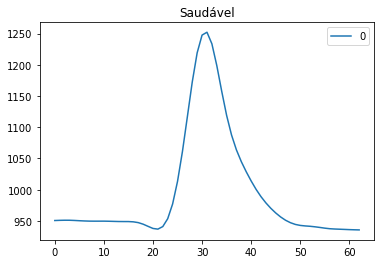

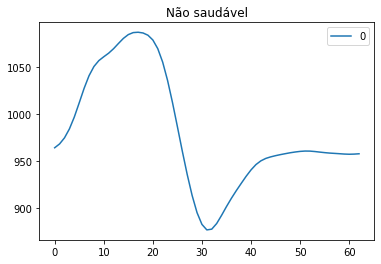

In [13]:
# Exemplo de duas ondas QRS
pd.DataFrame(df_features_train['QRS_wave'][1000]).plot(title="Saudável")
pd.DataFrame(df_features_train['QRS_wave'][5000]).plot(title="Não saudável")

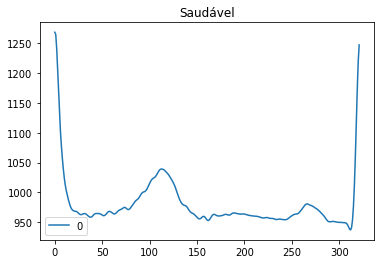

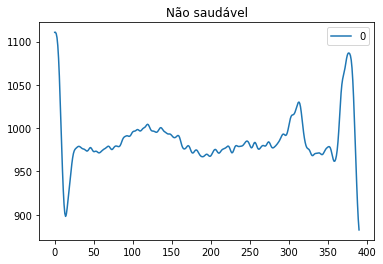

In [14]:
# Exemplo de duas ondas RR
pd.DataFrame(df_features_train['RR_wave'][1000]).plot(title="Saudável")
pd.DataFrame(df_features_train['RR_wave'][5000]).plot(title="Não saudável")

In [156]:
df_features_train['target_an'].value_counts()

0    37945
1     5134
Name: target_an, dtype: int64

In [27]:
tmp_data = df_features_train[df_features_train['target_n'] == 0]
tmp_data

,QRS_wave,RR_wave,QRS_ratio,QRS_var,QRS_time,QRS_diff,QRS_max_rate,QRS_max,QRS_min,RR_distance,target_n,target_an,target_description,file,RR_amplitude,RR_variance,RR_mean,RR_std
410,"[949.6734316443789, 949.1291224467042, 948.618...","[1263.6409309388587, 1237.8341564423868, 1197....",-0.931507,286.040312,41,317.061105,54.228511,1250.722642,933.661537,194,0,1,SVEB,101,329.979394,3080.844444,583.894949,791.199323
634,"[946.4997463673491, 947.9144524542766, 948.739...","[1261.269409552618, 1246.1184938717824, 1213.2...",-0.907895,304.582766,41,309.573951,55.815824,1247.849079,938.275128,333,0,1,SVEB,101,338.920478,320.988889,355.635354,19.561826
1526,"[975.6624904765936, 974.341587805012, 972.8312...","[1277.6145949751922, 1252.5535900044272, 1211....",-0.987500,353.682540,40,336.318490,61.460974,1271.435449,935.116959,237,0,1,SVEB,101,342.497636,1704.844444,473.894949,391.048000
1947,"[956.7320111409467, 956.9459468366805, 957.978...","[1364.2548008936387, 1376.7971147299888, 1363....",-0.351064,307.158226,44,468.881609,27.350443,1238.637703,769.756094,200,0,1,VEB,106,482.404486,1368.900000,382.900000,313.591468
1948,"[985.7205893091185, 985.8391607883311, 986.787...","[1238.637703111646, 1233.0820430432577, 1216.9...",-0.375000,205.258755,62,463.771011,22.651205,1317.108611,853.337600,178,0,1,VEB,106,547.352517,2357.433333,460.766667,601.384447
1950,"[1002.4100744361267, 1003.0331143972385, 1003....","[1390.8271848788604, 1397.974470329733, 1377.9...",-0.314815,377.209625,42,470.330693,26.820073,1225.130086,754.799393,177,0,1,VEB,106,447.610268,6068.233333,800.112121,1667.415674
1951,"[1021.9666319701109, 1020.29083252271, 1018.07...","[1225.1300864261377, 1223.394160172487, 1208.7...",-0.577778,122.324263,57,418.209762,20.408533,1303.057660,884.847897,167,0,1,VEB,106,545.201292,7204.666667,894.060606,1997.065250
1954,"[951.1632974784402, 952.9157135189071, 954.408...","[1369.6177903701785, 1365.6618873902644, 1333....",-0.387500,228.451247,51,408.386412,23.628384,1175.859898,767.473486,192,0,1,VEB,106,474.024887,13720.488889,1505.862626,3864.056848
1956,"[973.5557771333966, 974.2569377248841, 974.449...","[1372.4504370175612, 1385.9364469525776, 1375....",-0.392857,264.519274,38,424.919560,24.430040,1185.004112,760.084552,188,0,1,VEB,106,460.172524,16437.877778,1748.988889,4646.481987
1957,"[1001.2551279398892, 1000.9163573518521, 1001....","[1182.0994941581607, 1185.004112183043, 1177.5...",-0.586957,143.999496,57,441.699401,20.229879,1299.547916,857.848515,170,0,1,VEB,106,539.463363,17061.877778,1802.988889,4826.730646


## Análise das features

In [29]:
df_features_analysis = df_features_train

# Analisando cada classe de cardioparia individualmente
df_features_analysis = df_features_analysis[['QRS_ratio',
                                             'QRS_var',
                                             'QRS_time',
                                             'QRS_diff',
                                             'QRS_max_rate',
                                             'QRS_max',
                                             'QRS_min',
                                             'RR_distance',
                                             'RR_variance',
                                             'RR_mean',
                                             'RR_std',
                                             'target_description',
                                             'target_n',
                                             'RR_amplitude']]

df_features_analysis = df_features_analysis.dropna()


## Análise individual das features

### QRS_ratio

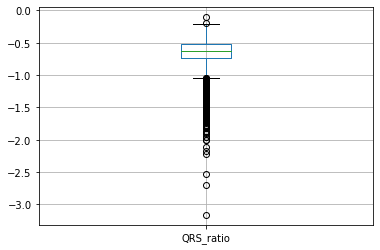

In [30]:
df_features_analysis.boxplot(column=['QRS_ratio'])

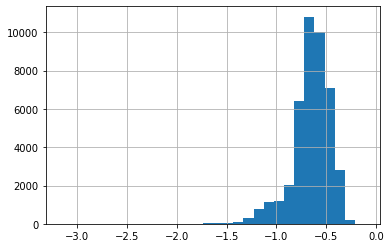

In [31]:
df_features_analysis['QRS_ratio'].hist(bins=30)

In [32]:
# Podemos considerar outliers baseado no gráfico de boxplot e no histograma
# df_features_analysis[df_features_analysis['QRS_ratio'] < .3]

In [33]:
# df_features_analysis = df_features_analysis[~(df_features_analysis['QRS_ratio'] < .3)]

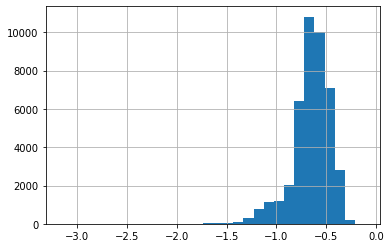

In [34]:
df_features_analysis['QRS_ratio'].hist(bins=30)

### QRS_var

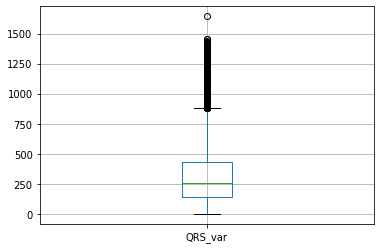

In [35]:
df_features_analysis.boxplot(column=['QRS_var'])

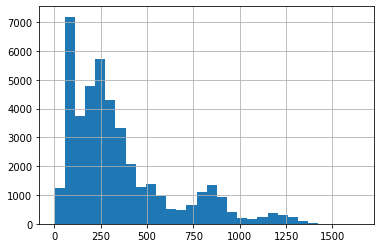

In [36]:
df_features_analysis['QRS_var'].hist(bins=30)

### QRS_time

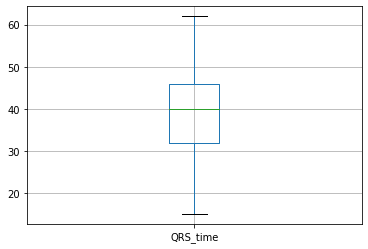

In [37]:
df_features_analysis.boxplot(column=['QRS_time'])

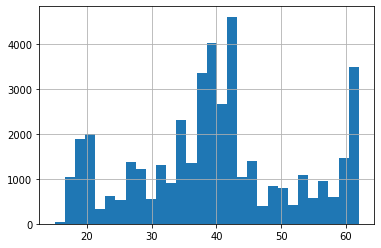

In [38]:
df_features_analysis['QRS_time'].hist(bins=30)

## QRS_diff

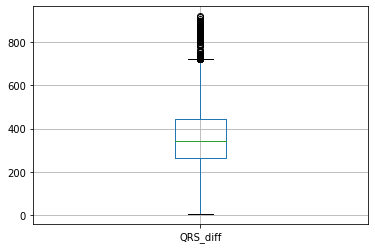

In [39]:
df_features_analysis.boxplot(column=['QRS_diff'])

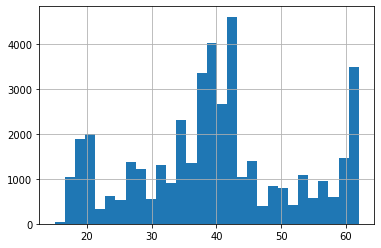

In [40]:
df_features_analysis['QRS_time'].hist(bins=30)

## QRS_max_rate

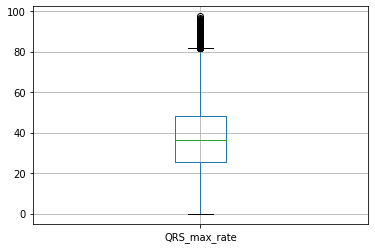

In [41]:
df_features_analysis.boxplot(column=['QRS_max_rate'])

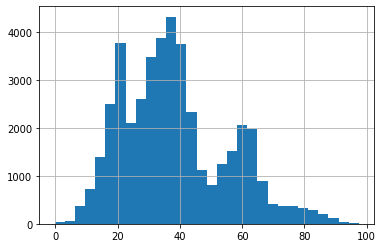

In [42]:
df_features_analysis['QRS_max_rate'].hist(bins=30)

### QRS_max (não usada)

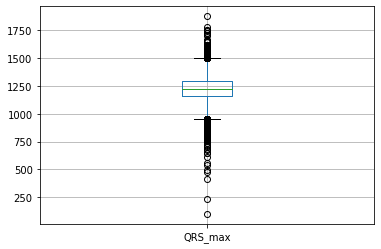

In [43]:
df_features_analysis.boxplot(column=['QRS_max'])

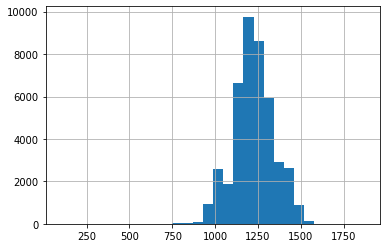

In [44]:
df_features_analysis['QRS_max'].hist(bins=30)

### QRS_min (não usada)

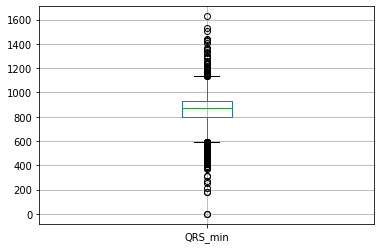

In [45]:
df_features_analysis.boxplot(column=['QRS_min'])

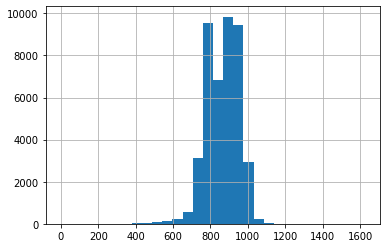

In [46]:
df_features_analysis['QRS_min'].hist(bins=30)

### RR_distance

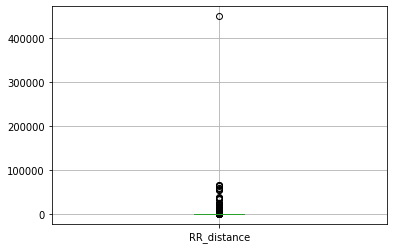

In [47]:
df_features_analysis.boxplot(column=['RR_distance'])

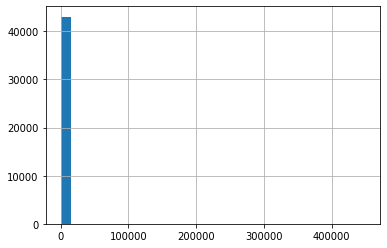

In [48]:
df_features_analysis['RR_distance'].hist(bins=30)

In [49]:
df_features_analysis[df_features_analysis['RR_distance'] > 100000]

,QRS_ratio,QRS_var,QRS_time,QRS_diff,QRS_max_rate,QRS_max,QRS_min,RR_distance,RR_variance,RR_mean,RR_std,target_description,target_n,RR_amplitude
26691,-0.470588,100.60645,58,423.557692,11.273655,1334.413941,910.856248,449546,2.002852e+10,1.820817e+09,5.757780e+09,VEB,0,1112.53328


In [50]:
df_features_analysis = df_features_analysis[~(df_features_analysis['RR_distance'] > 100000)]

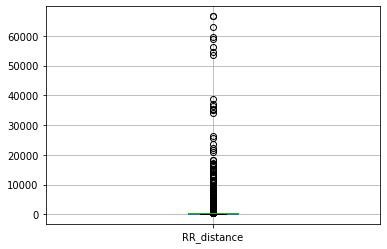

In [51]:
df_features_analysis.boxplot(column=['RR_distance'])

In [52]:
# Como os valores altos de RR_distance são referentes a VEB não irei remove-los
df_features_analysis[df_features_analysis['RR_distance'] > 40000]

,QRS_ratio,QRS_var,QRS_time,QRS_diff,QRS_max_rate,QRS_max,QRS_min,RR_distance,RR_variance,RR_mean,RR_std,target_description,target_n,RR_amplitude
5634,-0.379310,31.648526,53,259.672439,8.062314,1072.090057,812.417618,59047,3.839808e+08,3.492553e+07,1.103810e+08,VEB,0,626.579825
5646,-0.551020,150.376417,36,394.820425,22.383511,1113.176990,718.356566,53702,2.888403e+08,2.627080e+07,8.303176e+07,VEB,0,579.982678
18995,-0.604651,113.854875,59,313.895846,18.747599,843.337641,529.441796,59633,4.474812e+08,4.068933e+07,1.286389e+08,VEB,0,968.967369
19007,-0.333333,77.595868,52,335.504419,5.438213,937.361792,601.857373,66600,4.336121e+08,3.942606e+07,1.246526e+08,VEB,0,688.091901
19008,-0.636364,121.022676,61,342.528778,21.130035,888.747167,546.218389,63062,7.281392e+08,6.620695e+07,2.093214e+08,VEB,0,886.028902
19020,-1.163265,339.452255,29,439.265981,52.016902,1267.586843,828.320861,54529,2.889102e+08,2.627019e+07,8.305408e+07,SVEB,0,782.301474
19021,-0.333333,91.746032,51,352.309401,7.859887,873.831722,521.522322,66546,6.437077e+08,5.853044e+07,1.850493e+08,VEB,0,657.453425
19025,-1.000000,108.745528,62,344.489354,24.668678,870.622930,526.133576,56241,8.032814e+08,7.304219e+07,2.309219e+08,VEB,0,816.908699


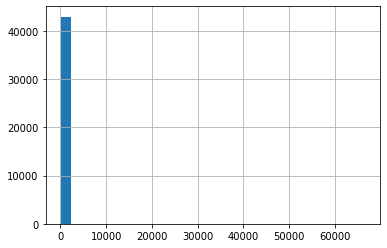

In [53]:
df_features_analysis['RR_distance'].hist(bins=30)

### RR_amplitude

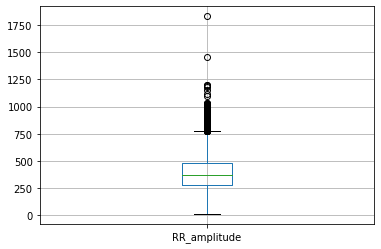

In [54]:
df_features_analysis.boxplot(column=['RR_amplitude'])

### RR_variance

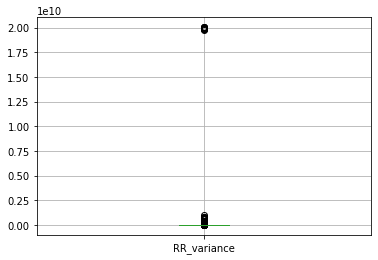

In [55]:
df_features_analysis.boxplot(column=['RR_variance'])

### RR_mean

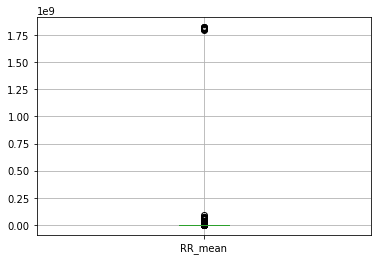

In [56]:
df_features_analysis.boxplot(column=['RR_mean'])

### RR_std

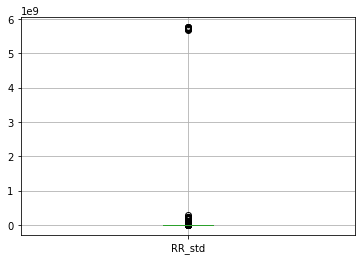

In [57]:
df_features_analysis.boxplot(column=['RR_std'])

In [58]:
df_features_analysis = df_features_analysis[df_features_analysis['RR_std'] < 2000000000]

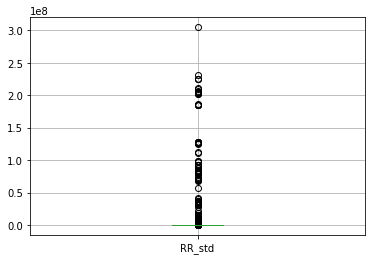

In [59]:
df_features_analysis.boxplot(column=['RR_std'])

## Análise dos grupos de features
É gerado um gráfico para cada dupla de features, dessa forma podemos ter noção de como os dados estão distribuidos no espaço

In [60]:
df_features_analysis

,QRS_ratio,QRS_var,QRS_time,QRS_diff,QRS_max_rate,QRS_max,QRS_min,RR_distance,RR_variance,RR_mean,RR_std,target_description,target_n,RR_amplitude
0,-0.955224,261.044848,33,284.198328,50.217579,1215.689455,931.491127,310,6126.055556,826.459596,1677.374127,NORMAL,1,300.153507
1,-0.919355,207.632149,41,265.152357,43.497202,1202.072956,936.920599,329,129.955556,304.359596,56.107078,NORMAL,1,284.912608
2,-1.142857,227.705467,36,276.329640,46.833392,1205.751663,929.422023,330,125.611111,305.510101,57.785270,NORMAL,1,267.026442
3,-1.100000,227.752834,41,261.483753,46.664233,1203.388942,941.905189,329,118.766667,306.160606,60.073468,NORMAL,1,277.543049
4,-1.076923,224.209625,41,257.919535,46.919584,1212.616727,954.697192,323,117.433333,306.221212,60.499323,NORMAL,1,261.483753
5,-1.064516,212.161250,40,246.510838,45.162271,1198.438917,951.928079,326,103.211111,304.019192,64.162559,NORMAL,1,259.908340
6,-0.923077,183.409927,33,231.623581,39.408103,1159.221884,927.598303,319,55.155556,297.377778,76.891402,NORMAL,1,248.516277
7,-1.122807,218.594356,38,260.007404,46.940406,1218.379452,958.372048,313,61.388889,296.944444,74.825592,NORMAL,1,297.810712
8,-1.166667,206.058957,41,261.796427,45.688085,1204.038481,942.242055,328,58.888889,298.080808,75.956956,NORMAL,1,267.524189
9,-1.244898,172.313933,41,245.881584,40.154880,1160.877733,914.996149,329,52.488889,298.953535,78.213986,NORMAL,1,265.959270


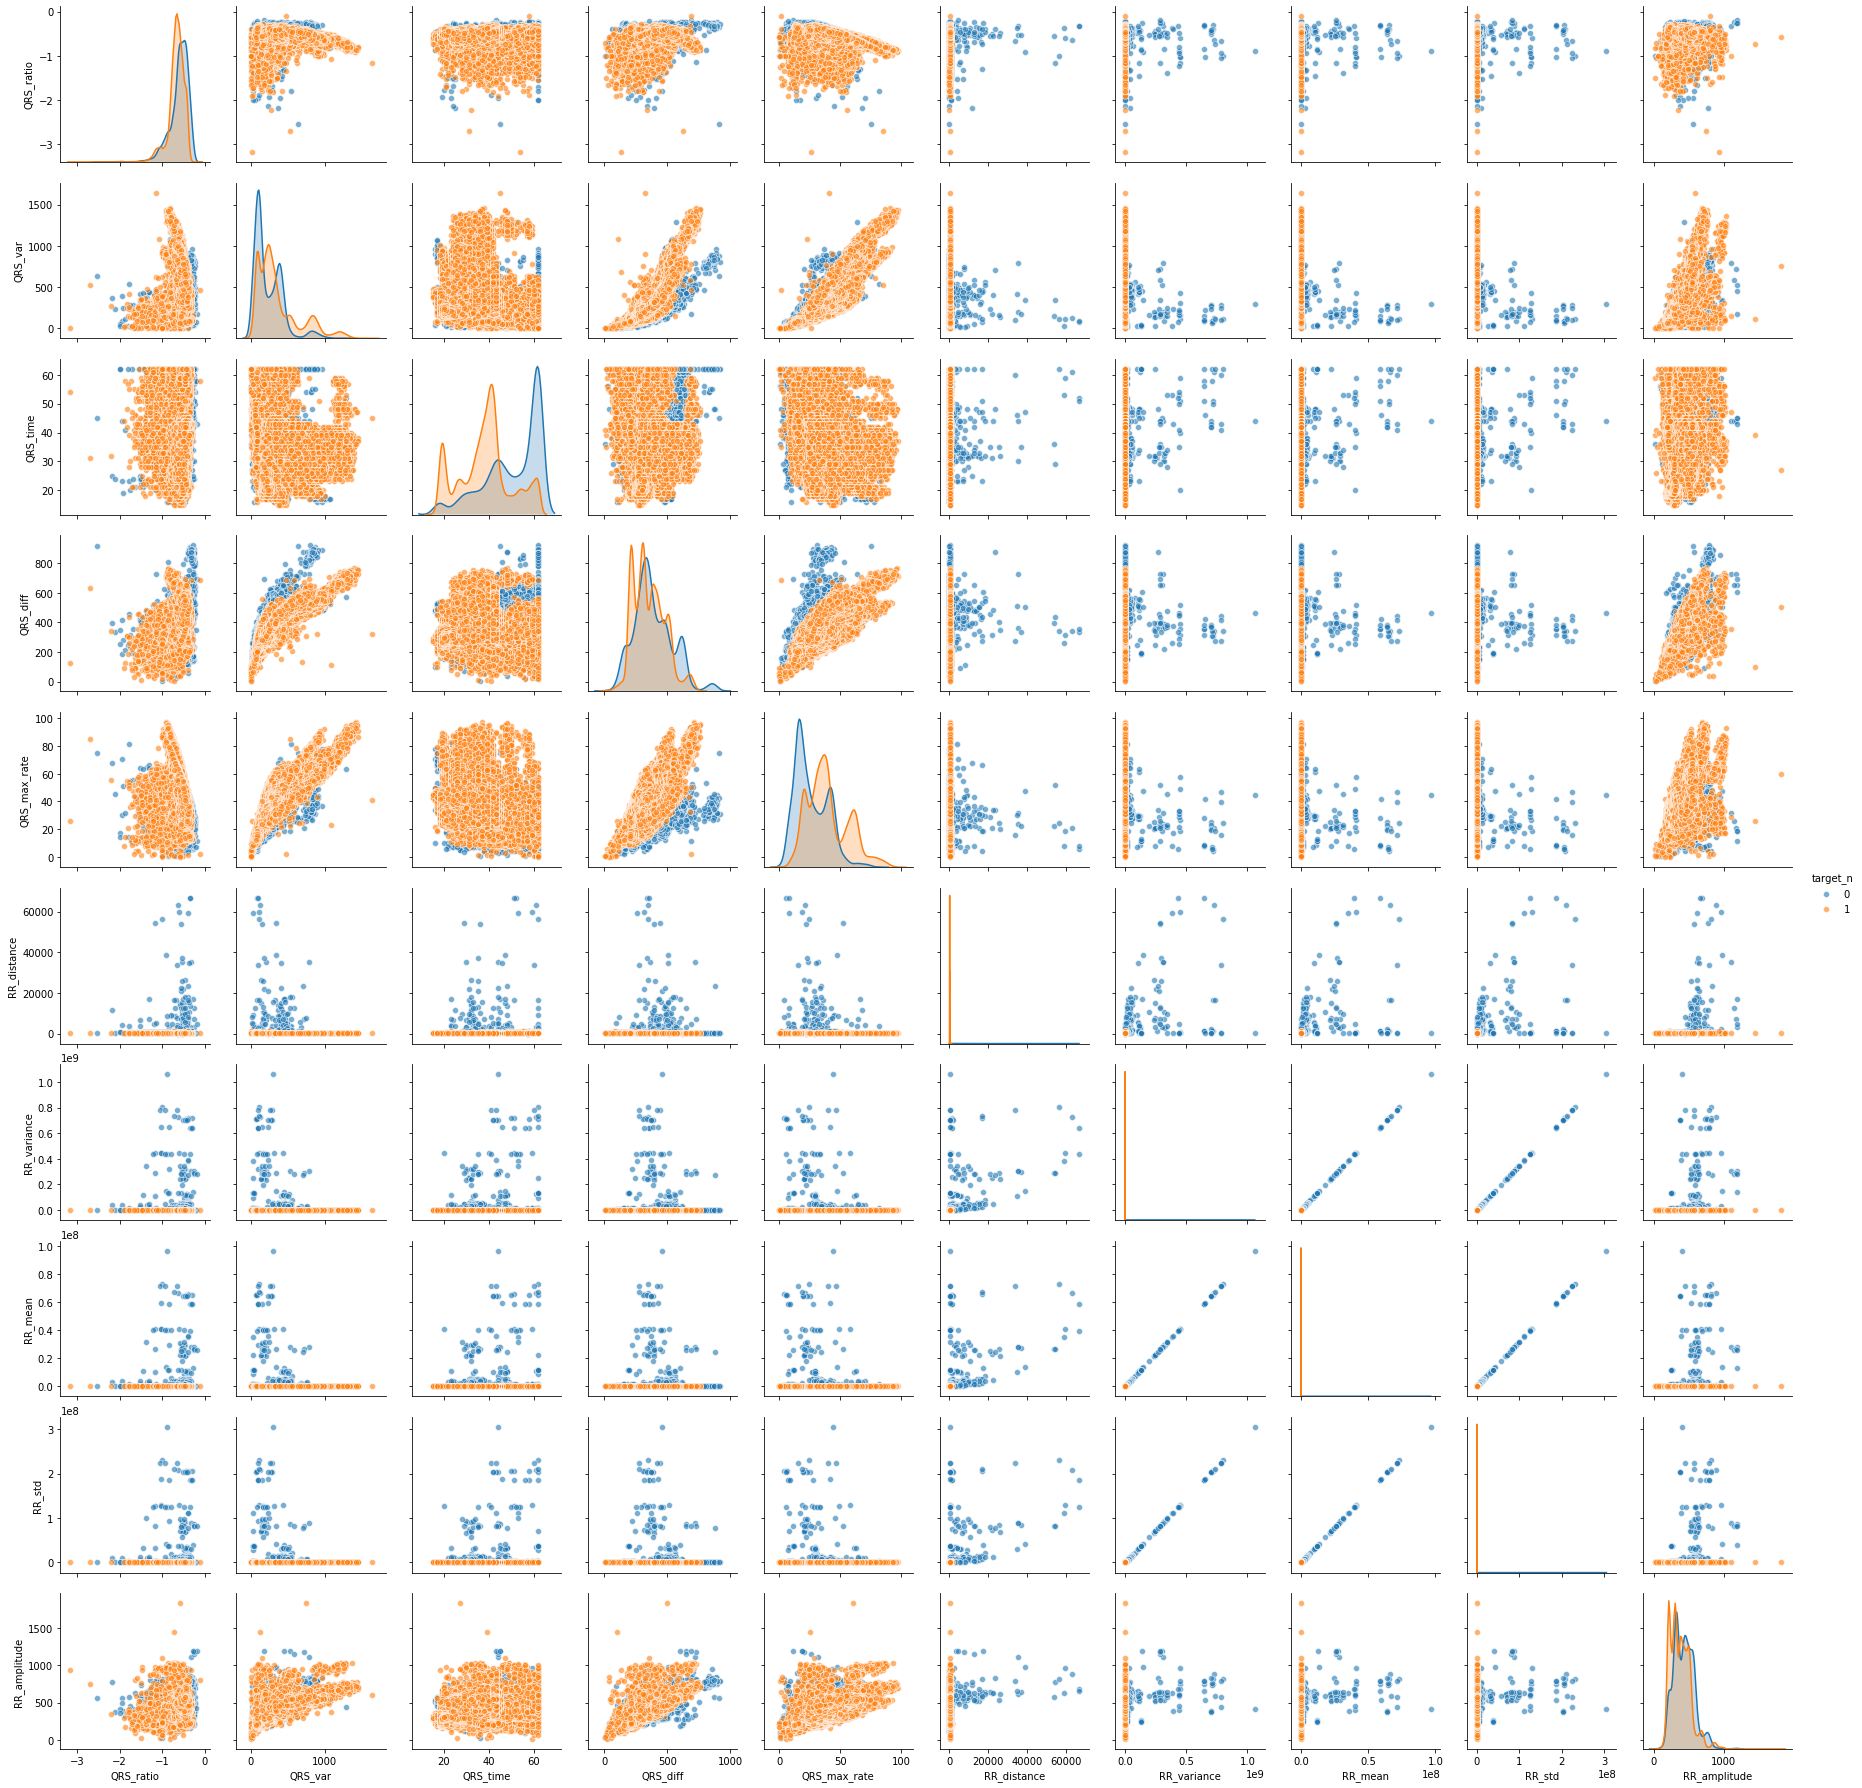

In [61]:
# Esse plot pode levar alguns minutos
sns.pairplot(df_features_analysis, 
             vars=['QRS_ratio',
                     'QRS_var',
                     'QRS_time',
                     'QRS_diff',
                     'QRS_max_rate',
                     'RR_distance',
                     'RR_variance',
                     'RR_mean',
                     'RR_std',
                     'RR_amplitude'], 
             hue="target_n", 
             plot_kws=dict(alpha=.6))

## Modelo MLP
O modelo escolhido foi o Multilayer Perceptron por ser amplamente usado na identificação de arritimias em sinais de ECG.

Para normalização dos dados foi escolhida a técnica de MinMax. A função de ativação utilizada nas camadas intermediárias foi tangente hiperbólica e por se tratar de uma classificação a ativação da camada de saída escolhida foi softmax (que retorna a probabilidade daquele registro ser da classe analisada)

In [64]:
def normalizationMinMax(data):
    data_norm = (data-data.min())/(data.max() - data.min())
    data_norm = data_norm
    return data_norm

In [66]:
df_features_train = df_features_train.drop(['QRS_wave','RR_wave','file'], axis=1)
df_features_test = df_features_test.drop(['QRS_wave','RR_wave','file'], axis=1)

In [69]:
def fix_feature_values(df_features, exception):
    columns = df_features.columns
    
    for i in columns:
        if exception in i:
            continue
        df_features[i] = normalizationMinMax(df_features[i])
    
    df_features = df_features.dropna()

    return df_features

df_features_train = fix_feature_values(df_features_train, 'target')
df_features_test = fix_feature_values(df_features_test, 'target')

df_features_train

,QRS_ratio,QRS_var,QRS_time,QRS_diff,QRS_max_rate,QRS_max,QRS_min,RR_distance,target_n,target_an,target_description,RR_amplitude,RR_variance,RR_mean,RR_std
0,0.723334,0.158915,0.382979,0.309347,0.516121,0.593888,0.455052,0.000489,1,0,NORMAL,0.157924,3.057469e-07,3.885724e-07,2.894717e-07
1,0.735066,0.126399,0.553191,0.288616,0.447362,0.587236,0.457704,0.000532,1,0,NORMAL,0.149537,6.377390e-09,1.018412e-07,7.901254e-09
2,0.661962,0.138619,0.446809,0.300782,0.481496,0.589034,0.454041,0.000534,1,0,NORMAL,0.139695,6.160484e-09,1.024730e-07,8.192711e-09
3,0.675980,0.138648,0.553191,0.284623,0.479765,0.587879,0.460139,0.000532,1,0,NORMAL,0.145482,5.818759e-09,1.028302e-07,8.590110e-09
4,0.683528,0.136491,0.553191,0.280743,0.482378,0.592387,0.466388,0.000518,1,0,NORMAL,0.136645,5.752189e-09,1.028635e-07,8.664069e-09
5,0.687586,0.129156,0.531915,0.268325,0.464398,0.585461,0.465036,0.000525,1,0,NORMAL,0.135778,5.042110e-09,1.016542e-07,9.300274e-09
6,0.733849,0.111653,0.382979,0.252120,0.405524,0.566303,0.453150,0.000510,1,0,NORMAL,0.129509,2.642823e-09,9.800682e-08,1.151093e-08
7,0.668520,0.133072,0.489362,0.283016,0.482591,0.595202,0.468184,0.000496,1,0,NORMAL,0.156635,2.954037e-09,9.776884e-08,1.115216e-08
8,0.654174,0.125441,0.553191,0.284963,0.469778,0.588197,0.460304,0.000530,1,0,NORMAL,0.139969,2.829218e-09,9.839292e-08,1.134864e-08
9,0.628585,0.104898,0.553191,0.267640,0.413165,0.567112,0.446994,0.000532,1,0,NORMAL,0.139107,2.509683e-09,9.887221e-08,1.174063e-08


## Processo de sub amostragem
Esse processo foi utilizado para melhorar um pouco o balanceamento dos registros. Porém isso pode impactar no recall.

In [70]:
# Under Sampling
df_features_train = df_features_train.sample(frac=1)
df_features_test = df_features_test.sample(frac=1)

df_features_train_ = df_features_train[df_features_train["target_an"] == 1]
df_features_train_ = df_features_train_.append(df_features_train[df_features_train["target_an"] == 0].sample(frac=.8))

df_features_test_ = df_features_test[df_features_test["target_an"] == 1]
df_features_test_ = df_features_test_.append(df_features_test[df_features_test["target_an"] == 0].sample(frac=.8))

len(df_features_train_)

In [75]:
df_features_train_ = df_features_train_.sample(frac=1)
df_features_test_ = df_features_test_.sample(frac=1)

In [76]:
df_features_train_.columns

Index(['QRS_ratio', 'QRS_var', 'QRS_time', 'QRS_diff', 'QRS_max_rate',
       'QRS_max', 'QRS_min', 'RR_distance', 'target_n', 'target_an',
       'target_description', 'RR_amplitude', 'RR_variance', 'RR_mean',
       'RR_std'],
      dtype='object')

In [77]:
# Separação dos conjuntos de treinamento e os targets
in_features = ['QRS_ratio', 
                 'QRS_var', 
                 'QRS_time',
                 'QRS_diff',
                 'QRS_max_rate',
                 'RR_distance',
                 'RR_mean',
                 'RR_std']

out_features = ['target_n', 'target_an']

df_inputs_train = df_features_train_[in_features]
df_target_train = df_features_train_[out_features]

df_inputs_test = df_features_test_[in_features]
df_target_test = df_features_test_[out_features]

## MLP própria

In [80]:
# Instanciação da classe da Rede Neural. Essa rede foi desenvolvida por nós, o código foi submetido 
# junto com o restante do trabalho e também pode ser encontrado em: https://github.com/GuilhermeSpadaccia/MachineLearning
nn = neural_network.neural_network(15)

In [82]:
train_error, validation_error = nn.fit(df_inputs_train.values, 
                                       df_target_train.values, 
                                       epochs=30, 
                                       learning_rate=0.003, 
                                       activation=["sigmoid","softmax"], 
                                       correction="stochastic")

Epoch:  30


/Users/guilherme/Documents/mestrado/mineracao_de_dados/arritmia/neural_network.py:115: RuntimeWarning: Mean of empty slice.
  return np.array(entrps).mean()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Train error:  0.40591684382184134
Validation error:  nan
Epoch:  29
Train error:  0.3722899919685727
Validation error:  nan
Epoch:  28
Train error:  0.33749766517889035
Validation error:  nan
Epoch:  27
Train error:  0.3271727976284257
Validation error:  nan
Epoch:  26
Train error:  0.32063482007514493
Validation error:  nan
Epoch:  25
Train error:  0.31486537982829693
Validation error:  nan
Epoch:  24
Train error:  0.3088714227779323
Validation error:  nan
Epoch:  23
Train error:  0.3025139430974483
Validation error:  nan
Epoch:  22
Train error:  0.2961778202231131
Validation error:  nan
Epoch:  21
Train error:  0.2903988267774107
Validation error:  nan
Epoch:  20
Train error:  0.2854907862919122
Validation error:  nan
Epoch:  19
Train error:  0.2814516653116306
Validation error:  nan
Epoch:  18
Train error:  0.2781252701704794
Validation error:  nan
Epoch:  17
Train error:  0.2753473018535591
Validation error:  nan
Epoch:  16
Train error:  0.2729909168532716
Validation error:  nan
Ep

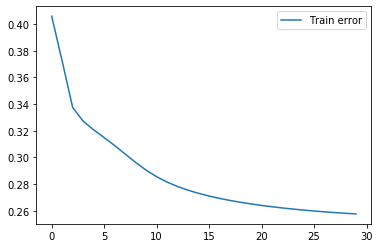

In [84]:
df_erros = pd.DataFrame(train_error)
df_erros.columns = ['train_error']
df_erros = df_erros.reset_index()

fig, ax = plt.subplots()
l1, = ax.plot(df_erros['index'].values, df_erros['train_error'].values)
ax.legend(['Train error'])
plt.show()

In [108]:
res = nn.predict(df_inputs_test.values)
res

[array([0.9335387, 0.0664613]),
 array([0.13809377, 0.86190623]),
 array([0.97169155, 0.02830845]),
 array([0.71049685, 0.28950315]),
 array([0.90355677, 0.09644323]),
 array([0.96144399, 0.03855601]),
 array([0.94889571, 0.05110429]),
 array([0.98325099, 0.01674901]),
 array([0.18611096, 0.81388904]),
 array([0.96956781, 0.03043219]),
 array([0.96888307, 0.03111693]),
 array([0.98768066, 0.01231934]),
 array([0.9483475, 0.0516525]),
 array([0.99386418, 0.00613582]),
 array([0.97277901, 0.02722099]),
 array([0.89101311, 0.10898689]),
 array([0.96990196, 0.03009804]),
 array([0.84403491, 0.15596509]),
 array([0.8051561, 0.1948439]),
 array([0.9584445, 0.0415555]),
 array([0.97121921, 0.02878079]),
 array([0.97859318, 0.02140682]),
 array([0.82662019, 0.17337981]),
 array([0.01232795, 0.98767205]),
 array([0.98401903, 0.01598097]),
 array([0.96974995, 0.03025005]),
 array([0.77671467, 0.22328533]),
 array([0.99025694, 0.00974306]),
 array([0.90517939, 0.09482061]),
 array([0.99169309, 0.

### Análise dos resultados

No handles with labels found to put in legend.


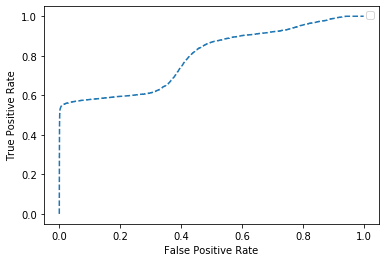

In [129]:
# Curva ROC
ns_fpr, ns_tpr, _ = roc_curve(df_target_test['target_an'].values, np.array(res)[:,1])

pyplot.plot(ns_fpr, ns_tpr, linestyle='--')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [130]:
# Aplicação do treshold
f_res = []
for i in res:
    if i[1] > .5:
        f_res.append(1)
    else:
        f_res.append(0)

In [131]:
df_final_res = df_target_test[['target_an']]
df_final_res['prediction'] = f_res

In [132]:
# Cáculo da acurácia
total = len(df_final_res)
acertos = len(df_final_res[df_final_res['target_an'] == df_final_res['prediction']])
erros = len(df_final_res[df_final_res['target_an'] != df_final_res['prediction']])

print("Acertos: {} -> {}%".format(acertos, round((acertos/total)*100, 2)))
print("Erros: {} -> {}%".format(erros, round((erros/total)*100, 2)))

Acertos: 31920 -> 92.11%
Erros: 2733 -> 7.89%


In [133]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(df_final_res['target_an'], df_final_res['prediction']).ravel()

### Cálculo dos indicadores da matriz de confusão

In [134]:
accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Acurácia: {accuracy}")

precision = tp/(tp+fp)
print(f"Precisão: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

fscore = 2*(recall * precision) / (recall + precision)
print(f"FScore: {fscore}")

Acurácia: 0.9211323694918189
Precisão: 0.978505291005291
Recall: 0.5258574728985249
FScore: 0.684082764998266


In [135]:
np.array([[tp,fp],[fn,tn]])

array([[ 2959,    65],
       [ 2668, 28961]])

In [136]:
df_features_test_['prediction'] = f_res

In [137]:
df_features_test_['target_description'].unique()

array(['NORMAL', 'VEB', 'F', 'SVEB'], dtype=object)

In [138]:
print('VEB:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'VEB')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'VEB') & (df_features_test_['prediction'] == 1)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')
print('----------------------')

print('SVEB:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'SVEB')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'SVEB') & (df_features_test_['prediction'] == 1)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')
print('----------------------')

print('F:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'F')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'F') & (df_features_test_['prediction'] == 1)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')
print('----------------------')

print('NORMAL:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'NORMAL')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'NORMAL') & (df_features_test_['prediction'] == 0)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')


VEB:
Total: 3199
Predicted: 2820
Percent: 0.8815254767114723
----------------------
SVEB:
Total: 2040
Predicted: 3
Percent: 0.0014705882352941176
----------------------
F:
Total: 388
Predicted: 136
Percent: 0.35051546391752575
----------------------
NORMAL:
Total: 29026
Predicted: 28961
Percent: 0.9977606284021222


## Benchmark MLP Scikit Learn

In [139]:
colunas = df_inputs_train.columns

In [140]:
mlp = MLPClassifier(hidden_layer_sizes=(20,10,5), max_iter=300, activation='relu', solver='sgd')

In [141]:
mlp.fit(df_inputs_train, df_target_train[['target_an']])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

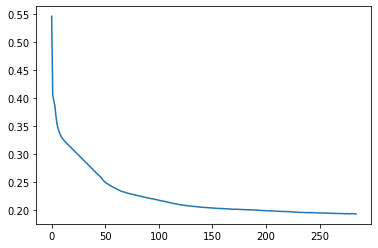

In [142]:
plt.plot(mlp.loss_curve_)

In [143]:
prediction = mlp.predict_proba(df_inputs_test)

### Análise dos resultados

No handles with labels found to put in legend.


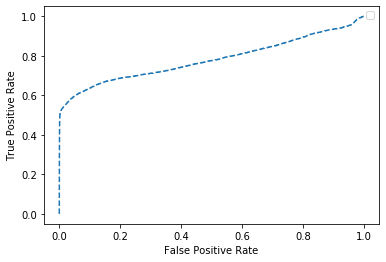

In [147]:
# Curva ROC
ns_fpr, ns_tpr, _ = roc_curve(df_target_test['target_an'].values, prediction[:,1])

pyplot.plot(ns_fpr, ns_tpr, linestyle='--')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

In [148]:
f_res = []
for i in prediction[:,1]:
    if i > .5:
        f_res.append(1)
    else:
        f_res.append(0)

In [149]:
df_target_test = df_target_test[['target_an']]

In [150]:
final_results_df = df_target_test.copy()
final_results_df['prediction'] = f_res

### Cálculo dos indicadores da matriz de confusão

In [152]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(final_results_df['target_an'], final_results_df['prediction']).ravel()

accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Acurácia: {accuracy}")

precision = tp/(tp+fp)
print(f"Precisão: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

fscore = 2*(recall * precision) / (recall + precision)
print(f"FScore: {fscore}")

print(np.array([[tp,fp],[fn,tn]]))

Acurácia: 0.8567512192306582
Precisão: 0.5510392609699769
Recall: 0.6360405189266038
FScore: 0.5904966177198481
[[ 3579  2916]
 [ 2048 26110]]


In [153]:
total = len(final_results_df)
acertos = len(final_results_df[final_results_df['target_an'] == final_results_df['prediction']])
erros = len(final_results_df[final_results_df['target_an'] != final_results_df['prediction']])

print("Acertos: {} -> {}%".format(acertos, round((acertos/total)*100, 2)))
print("Erros: {} -> {}%".format(erros, round((erros/total)*100, 2)))

Acertos: 29689 -> 85.68%
Erros: 4964 -> 14.32%


In [154]:
df_features_test_['prediction'] = f_res


In [155]:
print('VEB:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'VEB')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'VEB') & (df_features_test_['prediction'] == 1)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')
print('----------------------')

print('SVEB:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'SVEB')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'SVEB') & (df_features_test_['prediction'] == 1)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')
print('----------------------')

print('F:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'F')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'F') & (df_features_test_['prediction'] == 1)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')
print('----------------------')

print('NORMAL:')
len_veb = len(df_features_test_[(df_features_test_['target_description'] == 'NORMAL')])
print(f'Total: {len_veb}')
len_veb_pred = len(df_features_test_[(df_features_test_['target_description'] == 'NORMAL') & (df_features_test_['prediction'] == 0)])
print(f'Predicted: {len_veb_pred}')
print(f'Percent: {len_veb_pred/len_veb}')

VEB:
Total: 3199
Predicted: 3110
Percent: 0.9721788058768365
----------------------
SVEB:
Total: 2040
Predicted: 107
Percent: 0.052450980392156864
----------------------
F:
Total: 388
Predicted: 362
Percent: 0.9329896907216495
----------------------
NORMAL:
Total: 29026
Predicted: 26110
Percent: 0.8995383449321298


## Benchmark SVM

In [1628]:
from sklearn.svm import SVC

In [1638]:
svm = SVC(gamma=2, kernel='rbf', C=1, degree=3)
#svm = SVC(kernel='rbf', gamma=7)
svm.fit(df_inputs_train[colunas], df_target_train[['target_an']]) 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [1639]:
prediction = svm.predict(df_inputs_test[colunas])
df_target_test = df_target_test[['target_an']]
df_target_test['prediction'] = prediction

In [1640]:
tn, fp, fn, tp = confusion_matrix(df_target_test['target_an'], df_target_test['prediction']).ravel()

accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Acurácia: {accuracy}")

precision = tp/(tp+fp)
print(f"Precisão: {precision}")

recall = tp/(tp+fn)
print(f"Recall: {recall}")

fscore = 2*(recall * precision) / (recall + precision)
print(f"FScore: {fscore}")

print(np.array([[tp,fp],[fn,tn]]))

Acurácia: 0.9207860791273483
Precisão: 0.8694871794871795
Recall: 0.6026301759374445
FScore: 0.7118715230397817
[[ 3391   509]
 [ 2236 28517]]
